In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from hywaves.swan.storms import historic_track_preprocessing, historic_track_interpolation

# plotting
from hywaves.swan.plots.nonstationary import plot_project_site, plot_case_input, \
plot_case_output_grafiti, plot_case_vortex_grafiti, plot_case_output_points


## Load data

In [2]:
# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', '..', 'data'))
p_input_kwa = op.join(p_data, 'demo', 'nb_demo_kwa')

# load shoreline
np_shore = np.load(op.join(p_input_kwa, 'shore_kwa.npy'))

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_input_kwa, 'depth_kwa.nc'))

# load storms
ibtracs = xr.open_dataset(op.join(p_input_kwa, 'Allstorms.ibtracs_wmo.v03r10.nc'))


## SWAN Project

In [3]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_02_kwa'                  # project name

sp = SwanProject(p_proj, n_proj)

# some optional data (will be used at plotting)
sp.shore = np_shore  # project shoreline


## SWAN Main mesh

In [4]:
# get variables from bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]
depth = xds_bathy.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value (from file)
main_mesh.depth = depth

# computational grid description
res = 0.136  # (15km = 0.136º)  
main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),

}

sp.set_main_mesh(main_mesh)


## SWAN nested mesh

In [5]:
# lets cut inputh depth to a smaller area
xds_bathy_nest = xds_bathy.sel(
    lon = slice(165, 170),
    lat = slice(5, 10),
)

# get variables from bathymetry 
lon = xds_bathy_nest.lon.values[:]
lat = xds_bathy_nest.lat.values[:]
depth = xds_bathy_nest.elevation.values[:] * -1  # elevation to depth 

# SwanMesh object
mesh_nest = SwanMesh()

# depth grid description (input bathymetry grid)
mesh_nest.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
mesh_nest.dg_idla = 3

# depth value (from file)
mesh_nest.depth = depth

# computational grid description
res_nest = 0.04533
mesh_nest.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res_nest),
    'myc': int((lat[-1]-lat[0])/res_nest),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res_nest),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res_nest),

}

# set project nested mesh list
sp.set_nested_mesh_list([mesh_nest])


## SWAN case parameters

In [6]:

input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'SPHERICAL',
    'coords_projection': 'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '30 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '30 MIN',
    'output_deltt': '30 MIN',
    
    'output_points_x': [167.7336],
    'output_points_y': [8.66686],

    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],

    'numerics':[
        'PROP BSBT',
    ]
}
sp.set_params(input_params)


## SWAN input: storm track, no waves

In [7]:
# target coordinates
target = 'Kwajalein'
x0, y0 = 167.73, 8.72

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]


# select & extract storm data (v3.10) --> PAKA (december 1997)
storm = ibtracs.sel(storm=5628)

# preprocess storm variables
d_vns = {
    'longitude':'lon_wmo',
    'latitude':'lat_wmo',
    'time': 'time_wmo',
    'pressure':'pres_wmo',
    'maxwinds':'wind_wmo',
}

st_time, ylat_tc, ylon_tc, ycpres, ywind, ts, categ = historic_track_preprocessing(storm, d_vns)

# generate interpolated storm track  
dt_comp = 30  # min
st, time_input = historic_track_interpolation(
    st_time, ylon_tc, ylat_tc, ycpres, ywind,
    y0, x0, lat[0], lon[0], lat[-1], lon[-1],  
    ts, dt_comp, wind=ywind,
    great_circle=True
)

# generate empty wave event
we = pd.DataFrame(index=time_input, columns=['hs', 't02', 'dir', 'spr', 'U10', 'V10'])
we['level'] = 0
we['tide'] = 0


## Plot site configuration

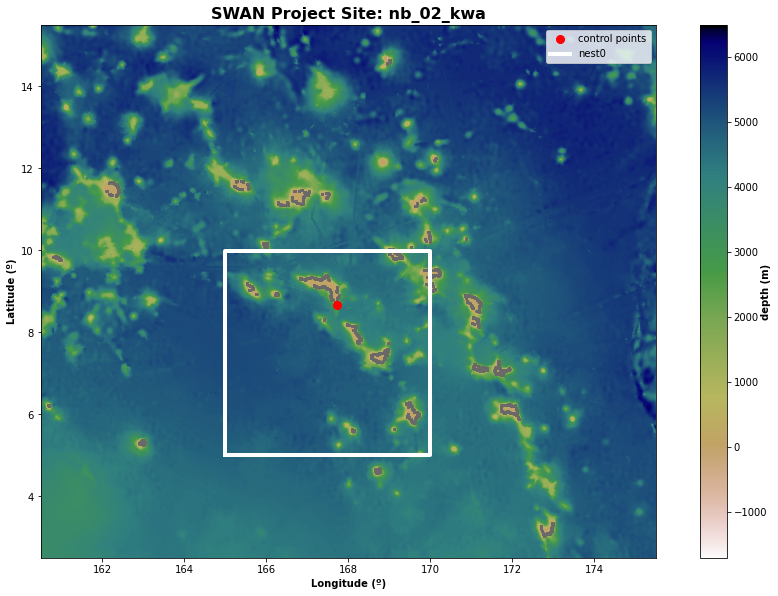

In [8]:
# plot site depth, control points, nested meshes (if any)
plot_project_site(sp);


## SWAN WRAP: build case

In [9]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)

# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases([we], storm_track_list=[st], make_waves=False)


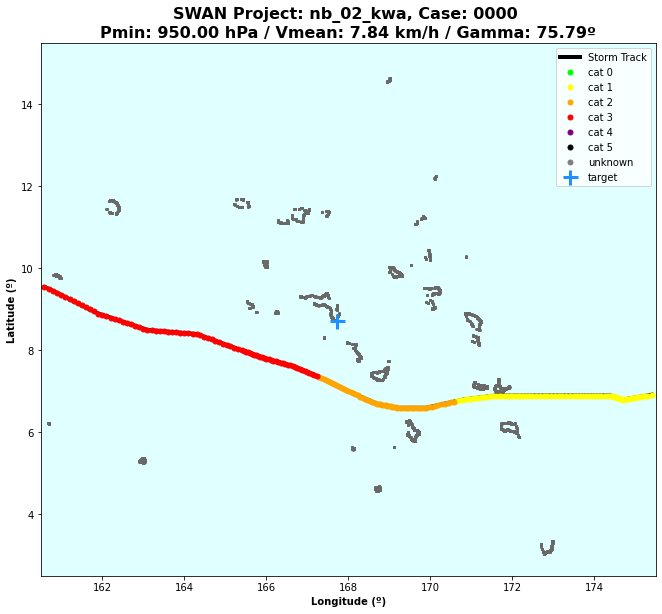

In [10]:
plot_case_input(sp, storm_track_list = [st]);

## Plot input: Grafiti Winds max.

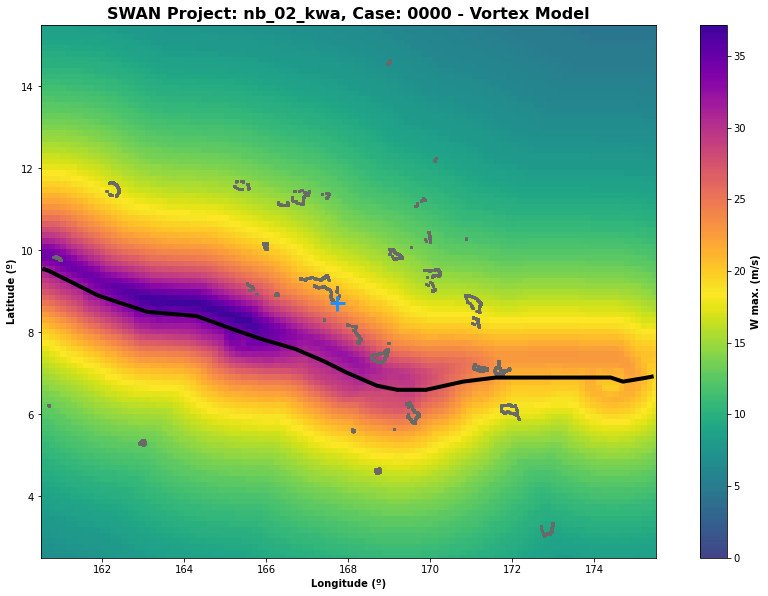

In [11]:
plot_case_vortex_grafiti(sw, storm_track_list = [st]);

## SWAN WRAP: run cases

In [12]:
sw.run_cases()

SWAN CASE: 0000 SOLVED


## Plot output: Grafiti Hsig max.

/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


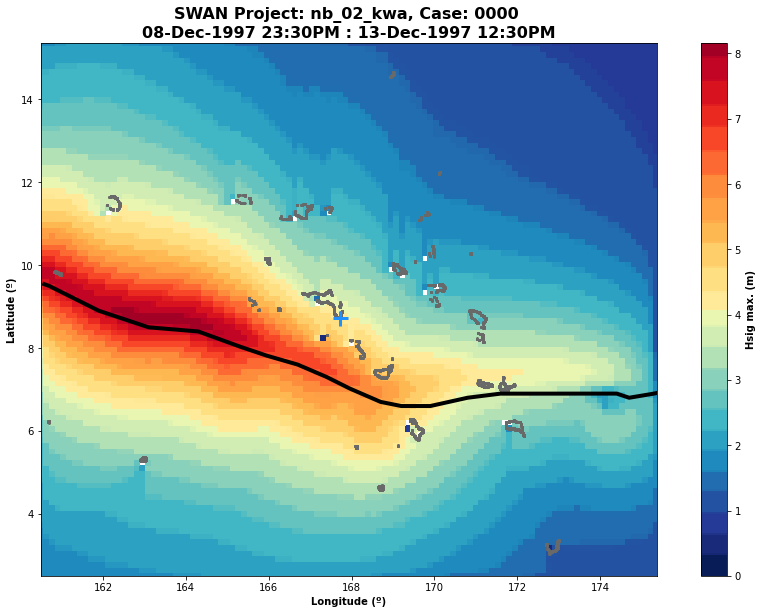

In [13]:
# Plot Hsig max - Main mesh
plot_case_output_grafiti(sw, storm_track_list = [st]);

/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/nico/Projects/BlueMath/HyWaves/venv/lib/python3.7/site-packages/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


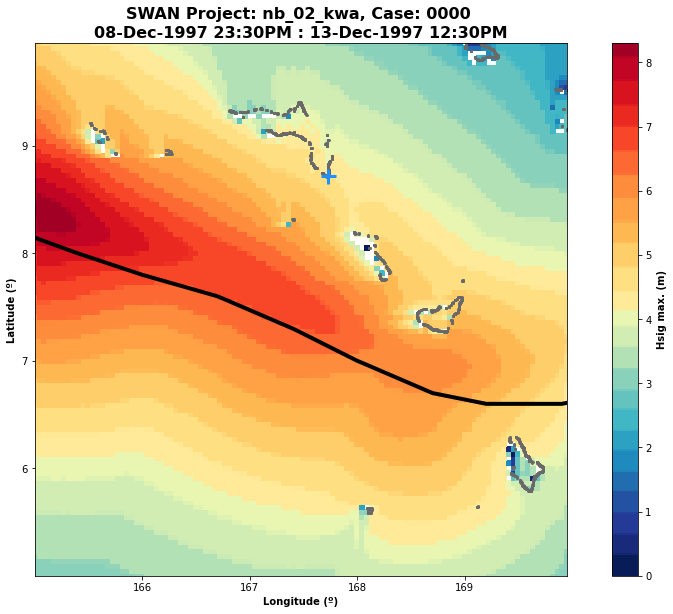

In [14]:
# Plot Hsig max - Nest mesh
plot_case_output_grafiti(sw, storm_track_list = [st], mesh=sp.mesh_nested_list[0]);

## Plot Output: Control Point

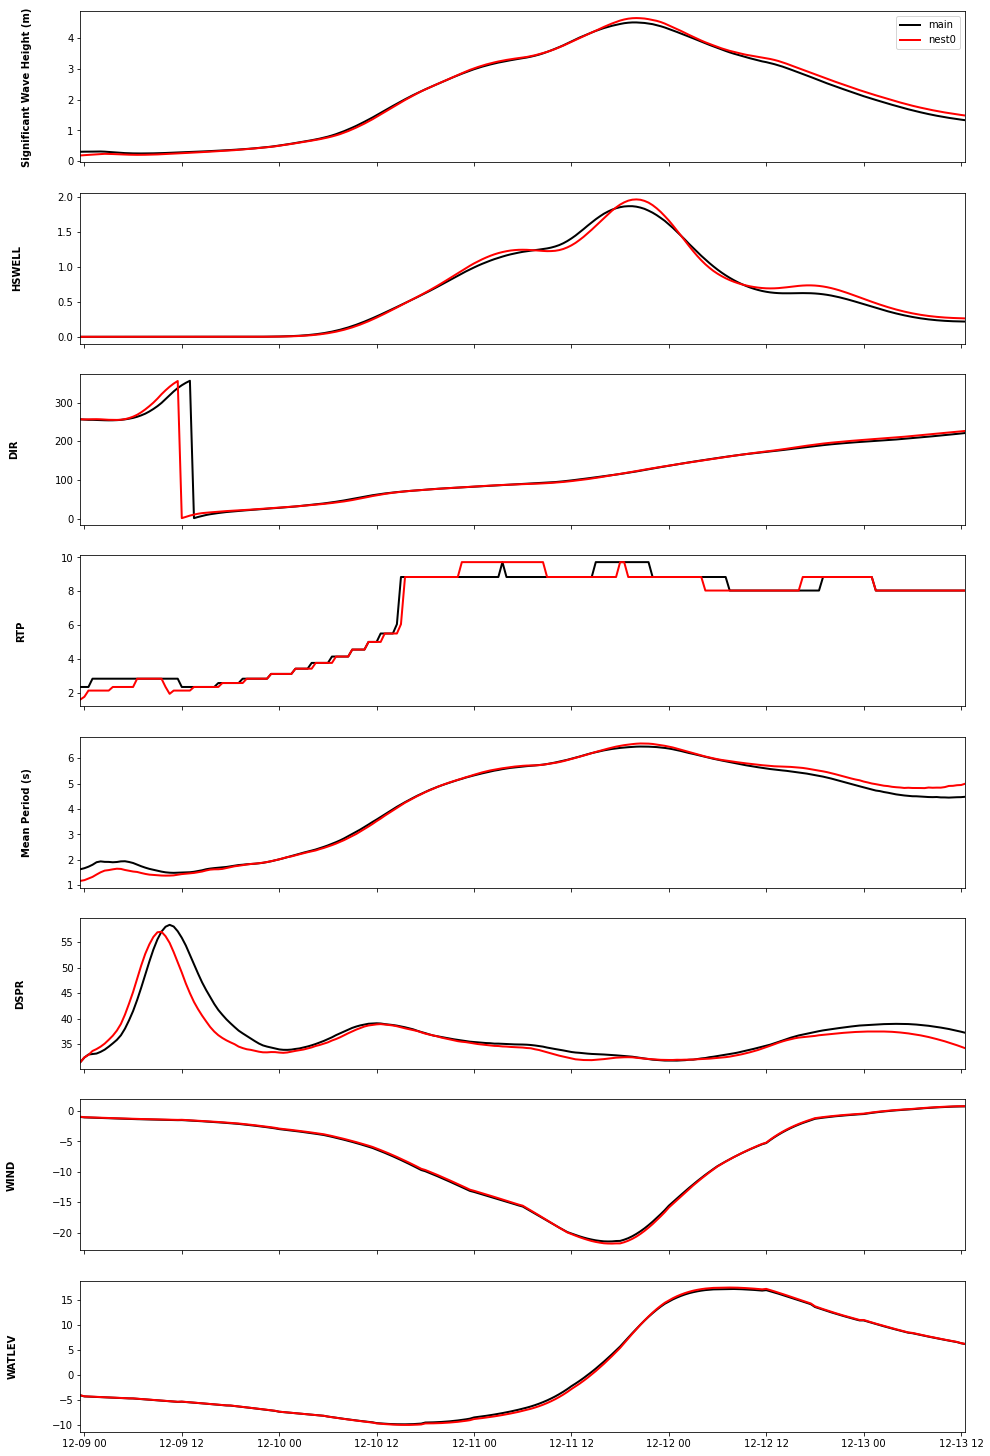

In [15]:
plot_case_output_points(sw);